In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    ################################################ s', Q = env(s, a)
    ################################################ ~s', ~Q = env(s, ~a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                   labels=next_states_labels)) # real loss
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
#     eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs_logits, # GAN
#                                                                     labels=tf.zeros_like(rates))) # min
#     aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs_logits, # GAN
#                                                                      labels=tf.ones_like(rates))) # max
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
#     eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs2_logits, # GAN
#                                                                     labels=tf.zeros_like(rates))) # min
#     aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs2_logits, # GAN
#                                                                      labels=tf.ones_like(rates))) # max
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a') # max
    ###################################################### ~Q(s,~a)= r # min
    ###################################################### ~Q(s,~a)= r + Q'(s',a') # max
    targetQs = rewards + (gamma * aQs2_logits)
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # minimize Q
    aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # maximize Q
    eloss += tf.reduce_mean(targetQs) # minimize Q
    aloss2 += -tf.reduce_mean(targetQs) # maxizmie Q
    eloss += tf.reduce_mean(eQs_logits) # minimize Q
    aloss2 += -tf.reduce_mean(eQs_logits) # maxizmie Q
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 aloss:0.6943 eloss:4.4026 aloss2:1.5488 exploreP:0.9979
Episode:1 meanR:19.5000 R:18.0000 rate:0.0360 aloss:0.6984 eloss:4.4037 aloss2:1.5435 exploreP:0.9961
Episode:2 meanR:17.6667 R:14.0000 rate:0.0280 aloss:0.6924 eloss:4.4171 aloss2:1.5133 exploreP:0.9948
Episode:3 meanR:18.2500 R:20.0000 rate:0.0400 aloss:0.7135 eloss:4.4187 aloss2:1.5103 exploreP:0.9928
Episode:4 meanR:17.8000 R:16.0000 rate:0.0320 aloss:0.6832 eloss:4.4322 aloss2:1.4747 exploreP:0.9912
Episode:5 meanR:21.5000 R:40.0000 rate:0.0800 aloss:0.6838 eloss:4.4193 aloss2:1.5078 exploreP:0.9873
Episode:6 meanR:20.7143 R:16.0000 rate:0.0320 aloss:0.6832 eloss:4.4084 aloss2:1.4997 exploreP:0.9857
Episode:7 meanR:19.7500 R:13.0000 rate:0.0260 aloss:0.6836 eloss:4.3855 aloss2:1.5558 exploreP:0.9845
Episode:8 meanR:20.3333 R:25.0000 rate:0.0500 aloss:0.6822 eloss:4.4044 aloss2:1.4965 exploreP:0.9820
Episode:9 meanR:22.4000 R:41.0000 rate:0.0820 aloss:0.6879 eloss:4.3767 aloss2:1.5

Episode:80 meanR:25.8889 R:19.0000 rate:0.0380 aloss:0.7045 eloss:4.2623 aloss2:2.0409 exploreP:0.8127
Episode:81 meanR:25.8293 R:21.0000 rate:0.0420 aloss:0.6879 eloss:4.2493 aloss2:2.0922 exploreP:0.8110
Episode:82 meanR:25.6506 R:11.0000 rate:0.0220 aloss:0.7075 eloss:4.2652 aloss2:2.1295 exploreP:0.8102
Episode:83 meanR:25.7143 R:31.0000 rate:0.0620 aloss:0.6896 eloss:4.2556 aloss2:2.1115 exploreP:0.8077
Episode:84 meanR:25.6353 R:19.0000 rate:0.0380 aloss:0.7069 eloss:4.2688 aloss2:2.1021 exploreP:0.8062
Episode:85 meanR:25.5465 R:18.0000 rate:0.0360 aloss:0.7035 eloss:4.2762 aloss2:2.0762 exploreP:0.8047
Episode:86 meanR:25.4138 R:14.0000 rate:0.0280 aloss:0.7280 eloss:4.2678 aloss2:2.0873 exploreP:0.8036
Episode:87 meanR:25.3864 R:23.0000 rate:0.0460 aloss:0.7128 eloss:4.2793 aloss2:2.1340 exploreP:0.8018
Episode:88 meanR:25.4944 R:35.0000 rate:0.0700 aloss:0.6917 eloss:4.2449 aloss2:2.1036 exploreP:0.7990
Episode:89 meanR:25.5000 R:26.0000 rate:0.0520 aloss:0.7007 eloss:4.2528 

Episode:159 meanR:36.2200 R:48.0000 rate:0.0960 aloss:0.7362 eloss:4.2495 aloss2:2.1703 exploreP:0.6047
Episode:160 meanR:35.9600 R:22.0000 rate:0.0440 aloss:0.7112 eloss:4.2549 aloss2:2.2155 exploreP:0.6034
Episode:161 meanR:36.0800 R:42.0000 rate:0.0840 aloss:0.7127 eloss:4.2500 aloss2:2.2190 exploreP:0.6009
Episode:162 meanR:35.9900 R:35.0000 rate:0.0700 aloss:0.7196 eloss:4.2511 aloss2:2.1999 exploreP:0.5988
Episode:163 meanR:36.2400 R:59.0000 rate:0.1180 aloss:0.7578 eloss:4.2484 aloss2:2.1533 exploreP:0.5953
Episode:164 meanR:36.6700 R:60.0000 rate:0.1200 aloss:0.7131 eloss:4.2526 aloss2:2.2089 exploreP:0.5918
Episode:165 meanR:36.5900 R:41.0000 rate:0.0820 aloss:0.7103 eloss:4.2431 aloss2:2.1803 exploreP:0.5895
Episode:166 meanR:36.5700 R:31.0000 rate:0.0620 aloss:0.7510 eloss:4.2492 aloss2:2.1981 exploreP:0.5877
Episode:167 meanR:37.6400 R:126.0000 rate:0.2520 aloss:0.7219 eloss:4.2479 aloss2:2.2128 exploreP:0.5804
Episode:168 meanR:37.8400 R:54.0000 rate:0.1080 aloss:0.7164 el

Episode:238 meanR:60.6600 R:14.0000 rate:0.0280 aloss:0.6958 eloss:4.2273 aloss2:2.2045 exploreP:0.3672
Episode:239 meanR:60.8700 R:56.0000 rate:0.1120 aloss:0.7112 eloss:4.2174 aloss2:2.2107 exploreP:0.3652
Episode:240 meanR:60.8700 R:33.0000 rate:0.0660 aloss:0.7205 eloss:4.2111 aloss2:2.2152 exploreP:0.3640
Episode:241 meanR:61.0200 R:36.0000 rate:0.0720 aloss:0.7187 eloss:4.2114 aloss2:2.2320 exploreP:0.3627
Episode:242 meanR:61.4800 R:97.0000 rate:0.1940 aloss:0.7095 eloss:4.2144 aloss2:2.2033 exploreP:0.3593
Episode:243 meanR:61.7200 R:63.0000 rate:0.1260 aloss:0.7140 eloss:4.2078 aloss2:2.2236 exploreP:0.3571
Episode:244 meanR:62.2000 R:66.0000 rate:0.1320 aloss:0.7184 eloss:4.2097 aloss2:2.2205 exploreP:0.3548
Episode:245 meanR:62.3100 R:80.0000 rate:0.1600 aloss:0.7057 eloss:4.2101 aloss2:2.2157 exploreP:0.3521
Episode:246 meanR:62.7000 R:64.0000 rate:0.1280 aloss:0.7224 eloss:4.2126 aloss2:2.2368 exploreP:0.3499
Episode:247 meanR:62.9800 R:64.0000 rate:0.1280 aloss:0.7021 elo

Episode:317 meanR:98.4800 R:218.0000 rate:0.4360 aloss:0.6818 eloss:4.2031 aloss2:2.2213 exploreP:0.1610
Episode:318 meanR:100.2000 R:203.0000 rate:0.4060 aloss:0.6810 eloss:4.2040 aloss2:2.2203 exploreP:0.1580
Episode:319 meanR:102.3000 R:258.0000 rate:0.5160 aloss:0.6948 eloss:4.2016 aloss2:2.2398 exploreP:0.1542
Episode:320 meanR:103.8100 R:197.0000 rate:0.3940 aloss:0.6869 eloss:4.1982 aloss2:2.2458 exploreP:0.1514
Episode:321 meanR:105.3700 R:239.0000 rate:0.4780 aloss:0.6835 eloss:4.2022 aloss2:2.2365 exploreP:0.1480
Episode:322 meanR:105.8900 R:247.0000 rate:0.4940 aloss:0.6802 eloss:4.2067 aloss2:2.2269 exploreP:0.1447
Episode:323 meanR:108.1200 R:271.0000 rate:0.5420 aloss:0.6939 eloss:4.2036 aloss2:2.2266 exploreP:0.1411
Episode:324 meanR:110.0000 R:232.0000 rate:0.4640 aloss:0.6899 eloss:4.2034 aloss2:2.2423 exploreP:0.1381
Episode:325 meanR:111.3300 R:221.0000 rate:0.4420 aloss:0.6922 eloss:4.2017 aloss2:2.2366 exploreP:0.1353
Episode:326 meanR:112.7900 R:235.0000 rate:0.47

Episode:395 meanR:283.6300 R:500.0000 rate:1.0000 aloss:0.6326 eloss:4.2662 aloss2:2.1669 exploreP:0.0230
Episode:396 meanR:283.2700 R:134.0000 rate:0.2680 aloss:0.6433 eloss:4.2628 aloss2:2.1685 exploreP:0.0229
Episode:397 meanR:283.1400 R:149.0000 rate:0.2980 aloss:0.6376 eloss:4.2645 aloss2:2.1651 exploreP:0.0227
Episode:398 meanR:286.6100 R:500.0000 rate:1.0000 aloss:0.6275 eloss:4.2666 aloss2:2.1625 exploreP:0.0220
Episode:399 meanR:289.7000 R:500.0000 rate:1.0000 aloss:0.6319 eloss:4.2592 aloss2:2.1799 exploreP:0.0215
Episode:400 meanR:290.1300 R:89.0000 rate:0.1780 aloss:0.6476 eloss:4.2545 aloss2:2.2079 exploreP:0.0214
Episode:401 meanR:293.3900 R:500.0000 rate:1.0000 aloss:0.6308 eloss:4.2581 aloss2:2.1930 exploreP:0.0208
Episode:402 meanR:294.5300 R:304.0000 rate:0.6080 aloss:0.6222 eloss:4.2655 aloss2:2.1873 exploreP:0.0205
Episode:403 meanR:297.8900 R:500.0000 rate:1.0000 aloss:0.6315 eloss:4.2646 aloss2:2.1940 exploreP:0.0200
Episode:404 meanR:300.7200 R:500.0000 rate:1.00

Episode:473 meanR:405.2100 R:166.0000 rate:0.3320 aloss:0.5500 eloss:4.2389 aloss2:2.6622 exploreP:0.0105
Episode:474 meanR:408.9200 R:500.0000 rate:1.0000 aloss:0.5352 eloss:4.2429 aloss2:2.6137 exploreP:0.0104
Episode:475 meanR:413.0600 R:500.0000 rate:1.0000 aloss:0.5327 eloss:4.2410 aloss2:2.6729 exploreP:0.0104
Episode:476 meanR:413.4400 R:500.0000 rate:1.0000 aloss:0.5297 eloss:4.2343 aloss2:2.6722 exploreP:0.0104
Episode:477 meanR:413.4400 R:500.0000 rate:1.0000 aloss:0.5346 eloss:4.2282 aloss2:2.7598 exploreP:0.0104
Episode:478 meanR:414.5200 R:500.0000 rate:1.0000 aloss:0.5332 eloss:4.2376 aloss2:2.7333 exploreP:0.0104
Episode:479 meanR:412.0200 R:250.0000 rate:0.5000 aloss:0.5306 eloss:4.2290 aloss2:2.7646 exploreP:0.0104
Episode:480 meanR:412.0200 R:500.0000 rate:1.0000 aloss:0.5252 eloss:4.2350 aloss2:2.7416 exploreP:0.0103
Episode:481 meanR:412.0200 R:500.0000 rate:1.0000 aloss:0.5342 eloss:4.2335 aloss2:2.8372 exploreP:0.0103
Episode:482 meanR:414.1600 R:500.0000 rate:1.0

Episode:551 meanR:468.9100 R:500.0000 rate:1.0000 aloss:0.4103 eloss:4.2147 aloss2:2.7205 exploreP:0.0100
Episode:552 meanR:468.9100 R:500.0000 rate:1.0000 aloss:0.4090 eloss:4.2146 aloss2:2.7371 exploreP:0.0100
Episode:553 meanR:468.9100 R:500.0000 rate:1.0000 aloss:0.4103 eloss:4.2172 aloss2:2.7692 exploreP:0.0100
Episode:554 meanR:472.7200 R:500.0000 rate:1.0000 aloss:0.4101 eloss:4.2227 aloss2:2.7701 exploreP:0.0100
Episode:555 meanR:472.7200 R:500.0000 rate:1.0000 aloss:0.4059 eloss:4.2164 aloss2:2.7847 exploreP:0.0100
Episode:556 meanR:472.7200 R:500.0000 rate:1.0000 aloss:0.4112 eloss:4.2264 aloss2:2.8101 exploreP:0.0100
Episode:557 meanR:475.7000 R:500.0000 rate:1.0000 aloss:0.4071 eloss:4.2220 aloss2:2.7902 exploreP:0.0100
Episode:558 meanR:475.7000 R:500.0000 rate:1.0000 aloss:0.4117 eloss:4.2272 aloss2:2.8055 exploreP:0.0100
Episode:559 meanR:477.5500 R:500.0000 rate:1.0000 aloss:0.4082 eloss:4.2273 aloss2:2.8027 exploreP:0.0100
Episode:560 meanR:477.5500 R:500.0000 rate:1.0

Episode:629 meanR:499.2000 R:500.0000 rate:1.0000 aloss:0.3656 eloss:4.0351 aloss2:3.2135 exploreP:0.0100
Episode:630 meanR:499.2000 R:500.0000 rate:1.0000 aloss:0.3662 eloss:4.0224 aloss2:3.2421 exploreP:0.0100
Episode:631 meanR:499.2000 R:500.0000 rate:1.0000 aloss:0.3642 eloss:4.0268 aloss2:3.2466 exploreP:0.0100
Episode:632 meanR:499.2000 R:500.0000 rate:1.0000 aloss:0.3664 eloss:4.0305 aloss2:3.2581 exploreP:0.0100
Episode:633 meanR:499.2000 R:500.0000 rate:1.0000 aloss:0.3653 eloss:4.0359 aloss2:3.2699 exploreP:0.0100
Episode:634 meanR:499.2000 R:500.0000 rate:1.0000 aloss:0.3668 eloss:4.0204 aloss2:3.2924 exploreP:0.0100
Episode:635 meanR:499.2000 R:500.0000 rate:1.0000 aloss:0.3659 eloss:4.0397 aloss2:3.2877 exploreP:0.0100
Episode:636 meanR:499.2000 R:500.0000 rate:1.0000 aloss:0.3665 eloss:4.0296 aloss2:3.3015 exploreP:0.0100
Episode:637 meanR:499.2000 R:500.0000 rate:1.0000 aloss:0.3653 eloss:4.0348 aloss2:3.2864 exploreP:0.0100
Episode:638 meanR:500.0000 R:500.0000 rate:1.0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

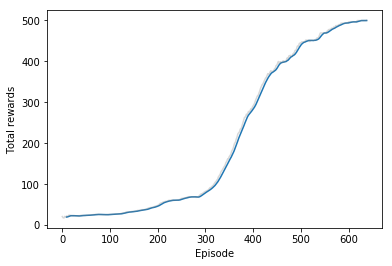

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

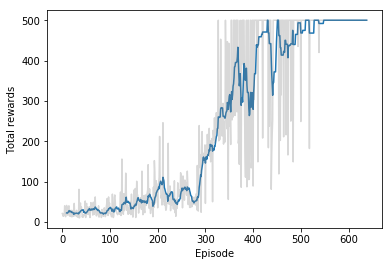

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

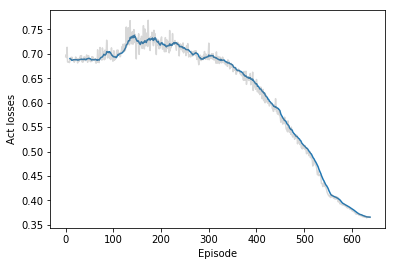

In [18]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

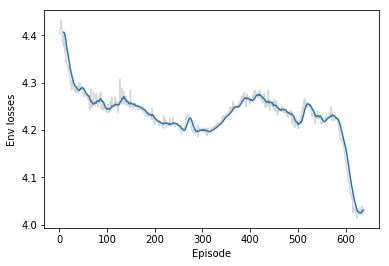

In [19]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

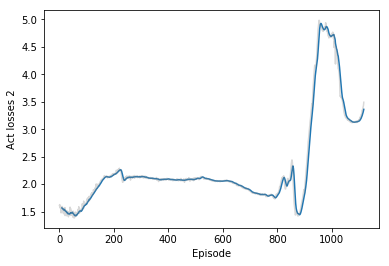

In [20]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
